Optimization terminated successfully.
         Current function value: 0.749633
         Iterations: 40
         Function evaluations: 76


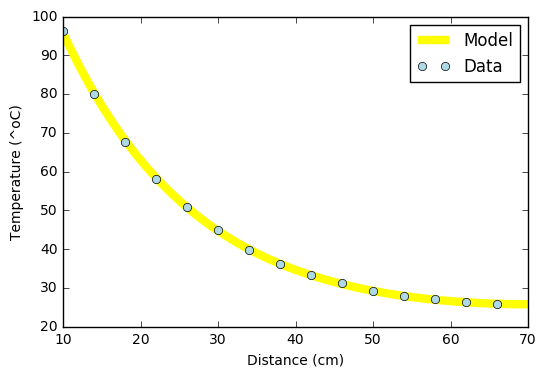

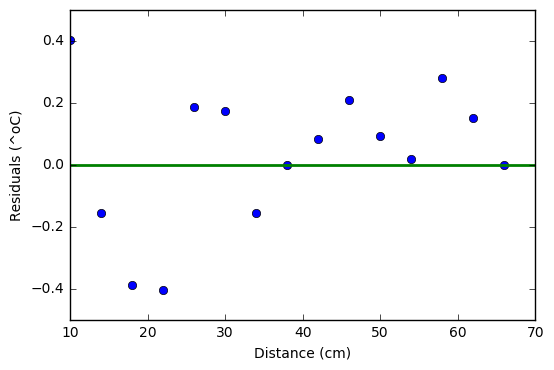

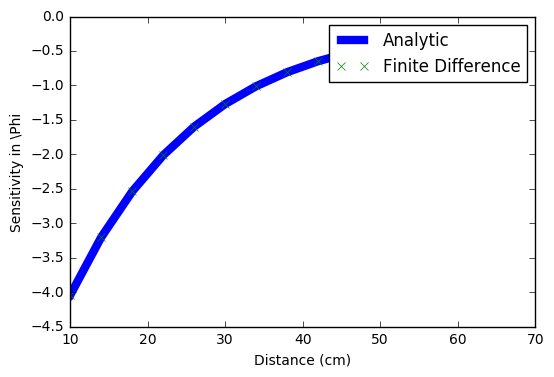

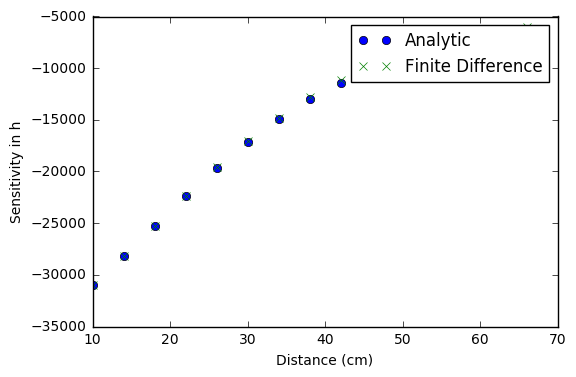

In [2]:
#                       heat_code.m
#
#
# Code computes optimal parameters, the sensitivity matrices, and covariance matrix 
#for the aluminum rod data analyzied in Example 7.16. 
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.io as sio
import matplotlib.axes as ax


#Load the data and construct the x datapoints. 

data = sio.loadmat('C:/Users/Marzieh/Desktop/Data and error analysis/Course_Materials/Week 2/Codes/data.mat')
xdata = [10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66]

def frange(start, stop, step):
        i = start
        while i < stop:
            yield i
            i += step
            
            
final_al_data2 = data['final_al_data']
final_al_data2=np.squeeze(final_al_data2)
data_al=final_al_data2[1:16]

xvals = list(frange(10,70,0.1))
u_amb = final_al_data2[16]


# Input dimensions and material constants for the alumunim rod. 


a = 0.95      # cm
b = 0.95      # cm
L = 70.0      # cm
k = 2.37      # W/cm C
n = 15        # Number of measurements
p = 2         # 3 Number of parameters
  

# Optimize parameters and construct increments used when approximating sensitivities using
# finite differences.  The representations are truncated to two significant digits to remain
# consistent with the measured temperatures. 


h_init = 0.00183
Q_init = -15.93
q_init = np.array([h_init, Q_init])

def heat_fun_al(q,a,b,L,k_al,u_amb_al):
      h = q[0]
      Q = q[1]
      gamma_al = np.sqrt(2*(a+b)*h/(a*b*k_al))
      f1_al = np.exp(gamma_al*L)*(h + k_al*gamma_al)
      f2_al = np.exp(-gamma_al*L)*(h - k_al*gamma_al)
      f3_al = f1_al/(f2_al + f1_al)
      c1_al = -Q*f3_al/(k_al*gamma_al)
      c2_al = Q/(k_al*gamma_al) + c1_al
      uvals_al = c1_al*np.exp(-gamma_al*np.array(xdata)) + c2_al*np.exp(gamma_al*np.array(xdata)) + float(u_amb_al)
      res_al = np.array(data_al) - uvals_al
      J = np.matmul(res_al,res_al.T)
      return J
      
 
f = lambda q,a,b,L,k,u_amb: heat_fun_al(q,a,b,L,k,u_amb)
q_opt = scipy.optimize.fmin(f,q_init, args=(a,b,L,k,u_amb,))      

h = q_opt[0]
Q = q_opt[1]
  
#h = 0.00191  
#Q = -18.41
 
dh = 1e-10
dQ = 1e-4
h_p = h + dh
Q_p = Q + dQ


#Construct constants and analytic solution to the steady state heat equation. 

gamma = np.sqrt(2*(a+b)*h/(a*b*k))
gamma_h = (1/(2*h))*gamma
f1 = np.exp(gamma*L)*(h + k*gamma)
f2 = np.exp(-gamma*L)*(h - k*gamma)
f3 = f1/(f2 + f1)
f1_h = np.exp(gamma*L)*(gamma_h*L*(h+k*gamma) + 1 + k*gamma_h)
f2_h = np.exp(-gamma*L)*(-gamma_h*L*(h-k*gamma) + 1 - k*gamma_h)
c1 = -Q*f3/(k*gamma)
c2 = Q/(k*gamma) + c1
f4 = Q/(k*gamma*gamma)
den2 = (f1+f2)**2
f3_h = (f1_h*(f1+f2) - f1*(f1_h+f2_h))/den2
c1_h = f4*gamma_h*f3 - (Q/(k*gamma))*f3_h
c2_h = -f4*gamma_h + c1_h
c1_Q = -(1/(k*gamma))*f3
c2_Q = (1/(k*gamma)) + c1_Q

gamma_hp = np.sqrt(2*(a+b)*h_p/(a*b*k))
f1_hp = np.exp(gamma_hp*L)*(h_p + k*gamma_hp)
f2_hp = np.exp(-gamma_hp*L)*(h_p - k*gamma_hp)
f3_hp = f1_hp/(f2_hp + f1_hp)
c1_hp = -Q*f3_hp/(k*gamma_hp)
c2_hp = Q/(k*gamma_hp) + c1_hp

c1_Qp = -Q_p*f3/(k*gamma)
c2_Qp = Q_p/(k*gamma) + c1_Qp

uvals = c1*np.exp(-gamma*np.array(xvals)) + c2*np.exp(gamma* np.array(xvals))+float(u_amb)
uvals_data = c1*np.exp(-gamma*np.array(xdata)) + c2*np.exp(gamma*np.array(xdata)) + float(u_amb)
uvals_Q_data = c1_Q*np.exp(-gamma*np.array(xdata)) + c2_Q*np.exp(gamma*np.array(xdata))
uvals_h_data = c1_h*np.exp(-gamma*np.array(xdata)) + c2_h*np.exp(gamma*np.array(xdata)) + (gamma_h*np.array(xdata))*(-c1*np.exp(-gamma*np.array(xdata))) + c2*np.exp(gamma*np.array(xdata))

uvals_data_hp = c1_hp*np.exp(-gamma_hp*np.array(xdata)) + c2_hp*np.exp(gamma_hp*np.array(xdata)) + float(u_amb)
uvals_data_Qp = c1_Qp*np.exp(-gamma*np.array(xdata)) + c2_Qp*np.exp(gamma*np.array(xdata)) + float(u_amb)

S_d = np.array([[np.array(np.ones((1,15)))], [np.array(xdata)],[np.array(xdata)**2], [np.array(xdata)**3], [np.array(xdata)**4]])
 
h_fd = (1/dh)*(uvals_data_hp - uvals_data)
Q_fd = (1/dQ)*(uvals_data_Qp - uvals_data)

res = np.array(data_al) - uvals_data

f = plt.figure()
plt.plot(xvals,uvals, linewidth=6,color='yellow',label='Model')
#plt.axis([5 70 20 100])
#ax.set_xlim(0.5, 4.5)
plt.plot(xdata,data_al,'ro', linewidth=5,color='lightblue',label='Data')
plt.xlabel('Distance (cm)')
plt.ylabel('Temperature (^oC)')
plt.legend()
plt.show()


f = plt.figure()
plt.plot(xdata,res,'o',linewidth=6)
#plt.axis([10 70 -.6 .4])
plt.plot(xvals,0*np.array(xvals),linewidth=2)
plt.ylabel('Temperature (^oC)')
plt.xlabel('Distance (cm)')
plt.ylabel('Residuals (^oC)')
plt.show()

# Construct the analytic and finite difference sensitivity matrices.

sens_mat = np.array([uvals_Q_data,uvals_h_data])
sens_mat_fd = np.array([Q_fd,h_fd])
  

# Construct the measurment covariance sigma2 and the covariance matrices
# V and V_fd constructed using the analytic and finite difference
# sensitivity relations.


sigma2 = (1/(n-p))*np.matmul(res,res.T)
V = sigma2*np.array(np.linalg.inv(np.matmul(sens_mat,sens_mat.T)))
V_fd = sigma2*np.array(np.linalg.inv(np.matmul(sens_mat_fd,sens_mat_fd.T)))


#Construct the 95% confidence intervals.

tval = 2.1604
int_Q = [Q - np.sqrt(V[0,0])*tval,  Q + np.sqrt(V[0,0])*tval]
int_h = [h - np.sqrt(V[1,1])*tval,  h + np.sqrt(V[1,1])*tval]


#Plot the sensitivities obtained analytically and using finite differences
# to show that to within visual accuracy, they are the same.
 
f = plt.figure()
plt.plot(xdata,uvals_Q_data,linewidth=6, label='Analytic') 
#plt.axis([0 70 -5 0]) 
plt.plot(xdata,Q_fd,'x',linewidth=4,label='Finite Difference')  
plt.xlabel('Distance (cm)')
plt.ylabel('Sensitivity in \Phi')
plt.legend()
plt.show()

f = plt.figure()
plt.plot(xdata,uvals_h_data,'o',linewidth=6,label='Analytic')
#plt.axis([0 70 -3.5e4 -0.5e4]) 
plt.plot(xdata,h_fd,'x',linewidth=6,label='Finite Difference')
plt.xlabel('Distance (cm)')
plt.ylabel('Sensitivity in h')
plt.legend()
plt.show()
